## Bingham Rotation Learning Demo


In [1]:
import torch
import numpy as np
from networks import *
from losses import *
from helpers_sim import *
import argparse


Create a parser object with our desired settings:

In [2]:
parser = argparse.ArgumentParser(description='Synthetic Wahba arguments.')
parser.add_argument('--sim_sigma', type=float, default=1e-2)
parser.add_argument('--N_train', type=int, default=500)
parser.add_argument('--N_test', type=int, default=100)
parser.add_argument('--matches_per_sample', type=int, default=25)

parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--batch_size_train', type=int, default=100)
parser.add_argument('--batch_size_test', type=int, default=100)
parser.add_argument('--lr', type=float, default=5e-4)

parser.add_argument('--dataset', choices=['static', 'dynamic', 'dynamic_beachball'], default='dynamic')
parser.add_argument('--beachball_sigma_factors', type=lambda s: [float(item) for item in s.split(',')], default=[0.1, 0.5, 2, 10], help='Heteroscedastic point cloud that has different noise levels (resembling a beachball).')
parser.add_argument('--max_rotation_angle', type=float, default=180., help='In degrees. Maximum axis-angle rotation of simulated rotation.')

parser.add_argument('--cuda', action='store_true', default=False)
parser.add_argument('--double', action='store_true', default=False)
parser.add_argument('--enforce_psd', action='store_true', default=False)
parser.add_argument('--unit_frob', action='store_true', default=False)

args = parser.parse_args([])
print(args)

Namespace(N_test=100, N_train=500, batch_size_test=100, batch_size_train=100, beachball_sigma_factors=[0.1, 0.5, 2, 10], cuda=False, dataset='dynamic', double=False, enforce_psd=False, epochs=100, lr=0.0005, matches_per_sample=25, max_rotation_angle=180.0, sim_sigma=0.01, unit_frob=False)


Specify the device to use while training

In [3]:
device = torch.device('cuda:0') if args.cuda else torch.device('cpu')
tensor_type = torch.double if args.double else torch.float

Generate the training and test data

In [4]:
if args.dataset == 'static':
    train_data, test_data = create_experimental_data_fast(args.N_train, args.N_test, args.matches_per_sample,
                                                          sigma=args.sim_sigma, device=device, dtype=tensor_type)
else:
    #Data will be generated on the fly
    train_data, test_data = None, None

Define our Bingham distribution model with `symeig`

In [5]:
def A_vec_to_quat(A_vec):
    A = convert_Avec_to_A(A_vec)
    _, evs = torch.symeig(A, eigenvectors=True)
    return evs[:,:,0].squeeze()

class BinghamNetDemo(torch.nn.Module):
    def __init__(self, enforce_psd=True, unit_frob_norm=True, batchnorm=False):
        super(BinghamNetDemo, self).__init__()
        self.A_net = PointNet(dim_out=10, normalize_output=False, batchnorm=batchnorm)
        self.enforce_psd = enforce_psd
        # self.unit_frob_norm = unit_frob_norm
        # self.qcqp_solver = QuadQuatFastSolver.apply

    def output_A(self, x):
        A_vec = self.A_net(x)
        if self.enforce_psd:
            A_vec = convert_Avec_to_Avec_psd(A_vec)
        if self.unit_frob_norm:
            A_vec = normalize_Avec(A_vec)

        return convert_Avec_to_A(A_vec)

    def forward(self, x):
        A_vec = self.A_net(x)

        # if self.enforce_psd:
        #     A_vec = convert_Avec_to_Avec_psd(A_vec)
        # if self.unit_frob_norm:
        #     A_vec = normalize_Avec(A_vec)
        # q = self.qcqp_solver(A_vec)
        q = A_vec_to_quat(A_vec)
        return q


Set up the cost function and model for our approach and the 2 baselines

In [6]:
model_quat = PointNet(dim_out=4, normalize_output=True).to(device=device, dtype=tensor_type)
loss_fn_quat = quat_chordal_squared_loss

model_6D = RotMat6DDirect().to(device=device, dtype=tensor_type)
loss_fn_6D = rotmat_frob_squared_norm_loss

model_bingham = QuatNet(enforce_psd=args.enforce_psd, unit_frob_norm=args.unit_frob).to(device=device, dtype=tensor_type)
loss_fn_bingham = quat_chordal_squared_loss

Train the models on the same data

/Users/mattgiamou/stars/code/bingham-rotation-learning/helpers_sim.py:209: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


RuntimeError: Subtraction, the `-` operator, with a bool tensor is not supported. If you are trying to invert a mask, use the `~` or `logical_not()` operator instead.

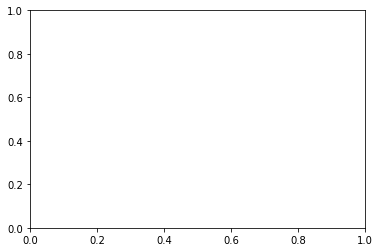

In [7]:
models = [model_quat, model_6D, model_bingham]
losses = [loss_fn_quat, loss_fn_6D, loss_fn_bingham]
(_, _) = train_test_models_with_plots(args, train_data, test_data, models, losses, rotmat_targets=False)
